# Preliminary Timing Test for ExaStar Review

## Lab notes
-----------
#### 28 October 2020
* Using PGI-19.9 for all builds and tests carried out here
* Using PGI-19.9 googletest and AMReX libraries in Summit setup previously
* The following is from `gatherDataCpp.447085`, which should match the compile time setup.  Note that Darshan is not loaded, which could affect timing results in general.
```
Currently Loaded Modules:
  1) pgi/19.9   2) spectrum-mpi/10.3.1.2-20200121   3) cuda/10.1.243
```
* Did preliminary testing to build up `GatherDataCpp` and committed final changes at commit 8166903b
* Using 16x16 blocks as these are the default block size for 2D in FLASH
* Klaus says that for their Paramesh testing with Sod, they have been using 73 blocks/MPI process in Summit.  Since they are not using the runtime and I believe that there is more than enough space per MPI process on Summit in MultiGPU mode (i.e. 1 MPI process per GPU), I have taken the liberty of executing the timing of $16^2 = 256$ total blocks so that we can get larger total walltimes and to bias the run more toward the GPU regime of launching several kernels at once with each containing many (thread) blocks.
* Built the suite of binaries required for collecting data with different mesh sizes so that confirmation of correct scaling can be done.  These are not being optimized by the compiler.
* Ran the `gatherDataCpp_lsf` job on Summit as Job 447085
* Manually altered `buildTestRuntimeCuda.sh` so that it will run its test with 16x16 blocks, but still with the same mesh spacings so that the test can still confirm proper execution.
* Built the Runtime CUDA binaries and setup the job script to enable GPU profiling so that I can estimate the walltime/block of the Laplacian code when run in the GPU.
  * Ran on Summit as job 447371
  * Profiling data is in file `TestRuntimeCuda.a29n06.154275` (Use CUDA nvvp)
  * I estimate approximately 230 us for an individual Laplacian kernel and see, as expected, that this is roughly valid for both the density and energy versions.
  * I estimate approximately 417.5 us for the fused kernel, which is close to twice the above value.

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from pathlib import Path
from platform import python_version
from matplotlib import __version__ as plt_version

plt.style.use('ggplot')

FONTSIZE = 16

# Define test setup of interest
NXB = 16
N_BLOCKS_X = 16

# Define order in which test configurations will be presented 
# in graphics
CFG_ORDER = ['gpu', 'cpu_gpu', 'gpu_fused', 'cpu_gpu_fused']

print()
print('Reproducibility Metadata')
print('-' * 60)
print(f'Started execution at {dt.datetime.now()}')
print(f'python     version\t{python_version()}')
print(f'numpy      version\t{np.__version__}')
print(f'scipy      version\t{sp.__version__}')
print(f'pandas     version\t{pd.__version__}')
print(f'matplotlib version\t{plt_version}')

#####----- gatherDataCpp test specification
N_GATHER_CPP_TRIALS = 20
GATHER_CPP_JOB_ID = 447085
GATHER_CPP_PATH = Path(f'gatherDataCpp_{GATHER_CPP_JOB_ID}')


Reproducibility Metadata
------------------------------------------------------------
Started execution at 2020-10-29 12:38:27.215233
python     version	3.7.7
numpy      version	1.18.5
scipy      version	1.5.0
pandas     version	1.0.5
matplotlib version	3.2.2


## The Test Problem
---------

The test problem
1. is defined on the square domain $\Omega = [0, 1] \times [0, 1]$,
2. must be discretized such that $\delta x = \delta y$, and
3. the domain decompositions must satisfy $N_B^x = N_B^y$,

where point (2) is used to simplify the numerical discretization of the Laplacian and (3) simplifies the timing analysis.  The data defined on the domain for the problem is "density" and "energy" with 
\\[
\rho(x,y) = 3x^3 + x^2 + x - 2y^3 - \frac{3}{2}y^2 + y + 5\\
E(x,y) = 4x^4 - 3x^3 + 2x^2 - x - y^4 + 2y^3 - 3y^2 + 4y + 1.
\\]

The problem is simply to approximate
\\[
f_{\rho}(x,y) = \Delta \rho(x, y)
\\]
and
\\[
f_E(x,y) = \Delta E(x, y)
\\]
for all $(x,y)$ in the discretization of $\Omega$ using the second-order approximation to the Laplacian.  

Note that $\rho$ was chosen so that the truncation error of the second-order Laplacian is zero; $E$, to have non-zero truncation error.  The known solutions are
\\[
f_{\rho}(x,y) = 18x - 12y - 1\\
f_E(x,y) = 48x^2 - 18x - 12y^2 + 12y - 2.
\\]

## Gather Data
------------
#### C++ Orchestration Runtime timing results

In [2]:
# Collect all raw data in single DataFrame
for j, fname in enumerate(GATHER_CPP_PATH.glob('gatherDataCpp_*_*_*_*_*_*.dat')):
    tmp_df = pd.read_csv(fname, comment="#")
    if j == 0:
        cpp_full_df = tmp_df.copy()
    else:
        cpp_full_df = pd.concat([cpp_full_df, tmp_df], ignore_index=True)
cpp_full_df = cpp_full_df.fillna(0.0)
cpp_full_df['n_thd_host'] = cpp_full_df.n_thd_host.astype(int)
cpp_full_df['n_thd_gpu'] = cpp_full_df.n_thd_gpu.astype(int)
cpp_full_df['n_tiles_per_packet'] = cpp_full_df.n_tiles_per_packet.astype(int)
cpp_full_df['n_tiles_per_cpu_turn'] = cpp_full_df.n_tiles_per_cpu_turn.astype(int)

# Confirm that all loaded data were collected with correct results
for dx in cpp_full_df.dx.unique():
    df = cpp_full_df[cpp_full_df.dx == dx]

    assert(len(df.Linf_density.unique()) == 1)
    assert(df.iloc[0].Linf_density < 1.0e-15)
    
    # The correctness of this single value is done manually by looking
    # at the scaling results below
    assert(len(df.Linf_energy.unique()) == 1)

# These define the different timing experiment runs
setups = ['pmode', 'n_loops', \
          'n_thd_host', 'n_thd_gpu', \
          'n_tiles_per_packet', 'n_tiles_per_cpu_turn', \
          'NXB', 'N_BLOCKS_X']

columns =    setups \
          + ['dx', 'Linf_density', 'Linf_energy']

# Create DataFrame of aggregate results
groups = cpp_full_df.groupby(setups).groups
for j, key in enumerate(groups):
    df = cpp_full_df.loc[groups[key]]
    assert(len(df) == N_GATHER_CPP_TRIALS)

    # Confirm that the only data that differs is the timing data
    # and that all expectations are met
    assert(len(df.NYB.unique()) == 1)
    assert(df.iloc[0].NXB == df.iloc[0].NYB)

    assert(len(df.NZB.unique()) == 1)
    assert(df.iloc[0].NZB == 1)

    assert(len(df.N_BLOCKS_Y.unique()) == 1)
    assert(df.iloc[0].N_BLOCKS_X == df.iloc[0].N_BLOCKS_Y)

    assert(len(df.N_BLOCKS_Z.unique()) == 1)
    assert(df.iloc[0].N_BLOCKS_Z == 1)

    assert(len(df.dx.unique()) == 1)
    assert(len(df.dy.unique()) == 1)
    assert(df.iloc[0].dx == df.iloc[0].dy)

    data = {}
    for each in columns:
        assert(each not in data)
        data[each] = [df.iloc[0][each]]

    data['wtime_min']  = [df.Walltime_sec.min()]
    data['wtime_mean'] = [df.Walltime_sec.mean()]
    data['wtime_max']  = [df.Walltime_sec.max()]
    data['wtime_std']  = [df.Walltime_sec.std()]
    
    tmp_df = pd.DataFrame(data=data)
    if j == 0:
        cpp_df = tmp_df.copy()
    else:
        cpp_df = cpp_df.append(tmp_df, ignore_index=True)

cpp_df['n_thd_host'] = cpp_df.n_thd_host.astype(int)
cpp_df['n_thd_gpu'] = cpp_df.n_thd_gpu.astype(int)
cpp_df['n_tiles_per_packet'] = cpp_df.n_tiles_per_packet.astype(int)
cpp_df['n_tiles_per_cpu_turn'] = cpp_df.n_tiles_per_cpu_turn.astype(int)

test_df = cpp_df[  (cpp_df.NXB == NXB) & (cpp_df.N_BLOCKS_X == N_BLOCKS_X)]
test_df

,pmode,n_loops,n_thd_host,n_thd_gpu,n_tiles_per_packet,n_tiles_per_cpu_turn,NXB,N_BLOCKS_X,dx,Linf_density,Linf_energy,wtime_min,wtime_mean,wtime_max,wtime_std
7,Runtime,1,2,5,10,0,16,16,0.003906,0,0.000092,0.002751,0.004029,0.007749,0.001051
13,Runtime,1,2,5,20,0,16,16,0.003906,0,0.000092,0.002373,0.002781,0.004482,0.000441
17,Runtime,1,2,5,30,0,16,16,0.003906,0,0.000092,0.002337,0.002544,0.003211,0.000203
21,Runtime,1,2,5,40,0,16,16,0.003906,0,0.000092,0.002324,0.002448,0.002645,0.000078
25,Runtime,1,2,5,50,0,16,16,0.003906,0,0.000092,0.002470,0.002641,0.003099,0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5337,RuntimeFused,1,6,1,256,50,16,16,0.003906,0,0.000092,0.002119,0.002248,0.003241,0.000258
5339,RuntimeFused,1,6,1,256,55,16,16,0.003906,0,0.000092,0.002113,0.002160,0.002264,0.000040
5341,RuntimeFused,1,6,1,256,60,16,16,0.003906,0,0.000092,0.002079,0.002134,0.002181,0.000035
5349,RuntimeFused,1,7,0,0,0,16,16,0.003906,0,0.000092,0.001555,0.001752,0.002355,0.000188


## Confirm Proper Scaling
--------

Energy Convergence Order (C++)	2.000000000000001


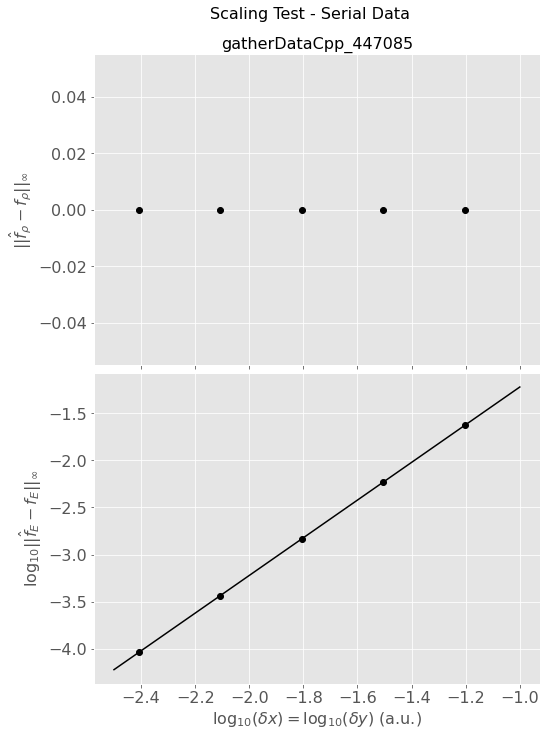

In [3]:
df = cpp_df[(cpp_df.pmode == 'Serial') & (cpp_df.n_loops == 1)]

# Data was intentionally acquired across the Cartesian product of
# NXB x N_BLOCKS_X.  As a result, there are different setups in the 
# product that yield the same dx = dy.  The errors should be identical for 
# all results with the same dx.  Therefore, we need only get one for each dx.
dx_all = sorted(df.dx.unique())
n_dx = len(dx_all)

Linf_density_cpp = np.full(n_dx, 0.0, dtype=float)
Linf_energy_cpp  = np.full(n_dx, 0.0, dtype=float)
for j, dx in enumerate(dx_all):
    tmp_df = df[df.dx == dx]
    Linf_density_cpp[j] = tmp_df.Linf_density.iloc[0]
    Linf_energy_cpp[j]  = tmp_df.Linf_energy.iloc[0]

fit_cpp = np.polyfit(np.log10(dx_all), \
                     np.log10(Linf_energy_cpp), 1)
print('Energy Convergence Order (C++)\t{}'.format(fit_cpp[0]))

X_DATA = [-2.5, -1.0]

plt.figure(1, figsize=(8, 11))
plt.suptitle('Scaling Test - Serial Data', fontsize=FONTSIZE)
plt.subplots_adjust(top=0.92, hspace=0.025, wspace=0.025)

subp1 = plt.subplot(211)
plt.title(GATHER_CPP_PATH, fontsize=FONTSIZE)
plt.plot(np.log10(dx_all), Linf_density_cpp, 'ok')
plt.ylabel(r'$||\hat{f}_{\rho} - f_{\rho}||_{\infty}$', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_visible(False)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)
    
subp2 = plt.subplot(212, sharex=subp1)
plt.plot(np.log10(dx_all), np.log10(Linf_energy_cpp), 'ok')
plt.plot(X_DATA, np.polyval(fit_cpp, X_DATA), '-k')
plt.xlabel(r'$\log_{10}(\delta x) = \log_{10}(\delta y)$ (a.u.)', fontsize=FONTSIZE)
plt.ylabel(r'$\log_{10} ||\hat{f}_{E} - f_{E}||_{\infty}$', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)

## Establish baseline serial results
------------

In [4]:
serial_df = cpp_df[(cpp_df.pmode == "Serial") & (cpp_df.NXB == NXB)]

print()
print("N blocks X\tN blocks\tWalltime (sec)\t\tWalltime/block (us)")
print('-' * 80)
for n_blks_x in sorted(serial_df.N_BLOCKS_X.unique()):
    df = serial_df[serial_df.N_BLOCKS_X == n_blks_x]
    assert(len(df) == 1)

    n_total_blks = n_blks_x**2

    # walltime is total time to apply the Laplacian twice to each block
    mean_walltime_sec = df.wtime_mean.values[0]

    # we want walltime/block for one Laplacian
    # this timing includes iterating and accessing the current block,
    # so it is a conservative estimate
    mean_walltime_per_blk_us = 0.5 * mean_walltime_sec / n_total_blks * 1.0e6

    print("{}\t\t{}\t\t{}\t{}".format(n_blks_x, n_total_blks, mean_walltime_sec, mean_walltime_per_blk_us))

serial_cpp_df = test_df[test_df.pmode == "Serial"]
walltime_serial_sec     = serial_cpp_df.wtime_mean.values[0]
walltime_serial_std_sec = serial_cpp_df.wtime_std.values[0]

cpp_full_df['speedup'] = walltime_serial_sec / cpp_full_df.Walltime_sec

print()
print('Serial time\t{} s'.format(walltime_serial_sec))


N blocks X	N blocks	Walltime (sec)		Walltime/block (us)
--------------------------------------------------------------------------------
2		4		0.00014991580000000608	18.73947500000076
4		16		0.000596764800000003	18.648900000000094
8		64		0.0023808327999999745	18.600256249999802
16		256		0.009566285350001948	18.684151074222555

Serial time	0.009566285350001948 s


## Locate best results & visualize
------------------

In [5]:
#####----- Serial baseline
# This is a DataFrame while the others are Series
serial_df = test_df[test_df.pmode == "Serial"]
serial_df.index = ['serial']

#####----- TWO-RUN GPU-ONLY
gpu_df = test_df[  (test_df.pmode == "Runtime") \
                 & (test_df.n_loops == 2) \
                 & (test_df.n_thd_host == 1)]
gpu_df = gpu_df.loc[gpu_df.wtime_mean.idxmin()]
gpu_df.name = 'gpu'

#####----- CONCURRENT CPU/GPU
cpu_gpu_df = test_df[  (test_df.pmode == "Runtime") \
                     & (test_df.n_loops == 1)]
cpu_gpu_df = cpu_gpu_df.loc[cpu_gpu_df.wtime_mean.idxmin()]
cpu_gpu_df.name = 'cpu_gpu'

#####----- GPU WITH FUSED KERNELS
gpu_fused_df = test_df[  (test_df.pmode == "RuntimeFused") \
                       & (test_df.n_loops == 1) \
                       & (test_df.n_thd_host == 1) \
                       & (test_df.n_thd_gpu > 0) \
                       & (test_df.n_tiles_per_cpu_turn == 0)]
gpu_fused_df = gpu_fused_df.loc[gpu_fused_df.wtime_mean.idxmin()]
gpu_fused_df.name = 'gpu_fused'

#####----- DATA-PARALLEL CPU/GPU / FUSED
split_fused_df = test_df[  (test_df.pmode == "RuntimeFused") \
                         & (test_df.n_loops == 1) \
                         & (test_df.n_tiles_per_cpu_turn > 0)]
split_fused_df = split_fused_df.loc[split_fused_df.wtime_mean.idxmin()]
split_fused_df.name = 'cpu_gpu_fused'

best_df = pd.concat([serial_df.T, gpu_df, cpu_gpu_df, gpu_fused_df, split_fused_df], \
                    axis=1)
best_df

,serial,gpu,cpu_gpu,gpu_fused,cpu_gpu_fused
pmode,Serial,Runtime,Runtime,RuntimeFused,RuntimeFused
n_loops,1,2,1,1,1
n_thd_host,1,1,5,1,5
n_thd_gpu,0,4,2,1,2
n_tiles_per_packet,0,110,110,180,60
n_tiles_per_cpu_turn,0,0,0,0,50
NXB,16,16,16,16,16
N_BLOCKS_X,16,16,16,16,16
dx,0.00390625,0.00390625,0.00390625,0.00390625,0.00390625
Linf_density,0,0,0,0,0


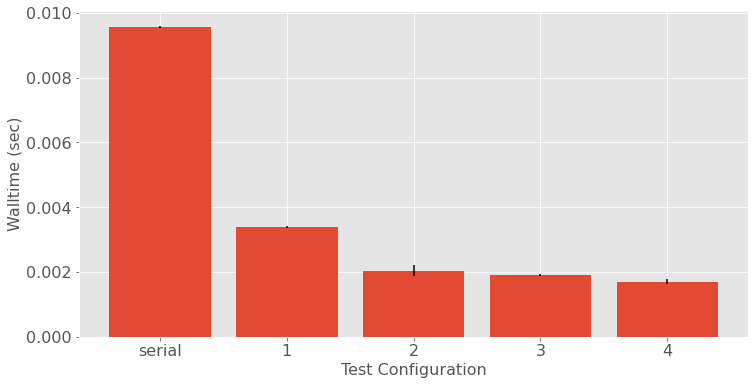

In [6]:
wtime_order = ['serial'] + CFG_ORDER

wtimes     = [best_df.loc['wtime_mean', key] for key in wtime_order]
wtimes_err = [best_df.loc['wtime_std',  key] for key in wtime_order]

plt.figure(2, figsize=(12, 6))

subp = plt.subplot(111)
plt.bar(range(len(wtimes)), wtimes, yerr=wtimes_err)
subp.set_xticks(range(len(wtimes)))
subp.set_xticklabels(['serial'] + list(range(1, len(CFG_ORDER)+1)))
plt.xlabel("Test Configuration", fontsize=FONTSIZE)
plt.ylabel("Walltime (sec)", fontsize=FONTSIZE)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)

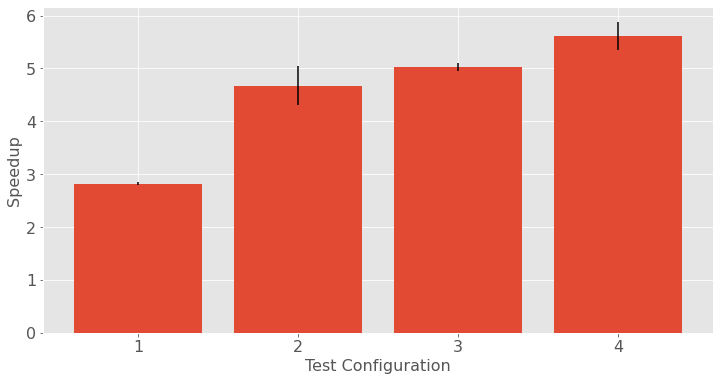

In [7]:
def speedup_std(wtime, wtime_std):
    return   walltime_serial_sec / wtime \
           * np.sqrt((walltime_serial_std_sec / walltime_serial_sec)**2 + (wtime_std / wtime)**2)

speedup     = [walltime_serial_sec / best_df.loc['wtime_mean', key] for key in CFG_ORDER]
speedup_err = [speedup_std(best_df.loc['wtime_mean', key], best_df.loc['wtime_std', key]) \
                   for key in CFG_ORDER]

plt.figure(3, figsize=(12, 6))

subp = plt.subplot(111)
plt.bar(range(len(speedup)), speedup, yerr=speedup_err)
subp.set_xticks(range(len(speedup)))
subp.set_xticklabels(range(1, len(speedup)+1))
plt.xlabel("Test Configuration", fontsize=FONTSIZE)
plt.ylabel("Speedup", fontsize=16)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)

In [8]:
wtimes_data  = {}
speedup_data = {}

for key in CFG_ORDER:
    df = best_df[key]
    raw_df = cpp_full_df[  (cpp_full_df.pmode == df.pmode) \
                         & (cpp_full_df.n_loops == df.n_loops) \
                         & (cpp_full_df.n_thd_host == df.n_thd_host) \
                         & (cpp_full_df.n_thd_gpu == df.n_thd_gpu) \
                         & (cpp_full_df.n_tiles_per_packet == df.n_tiles_per_packet) \
                         & (cpp_full_df.n_tiles_per_cpu_turn == df.n_tiles_per_cpu_turn) \
                         & (cpp_full_df.NXB == df.NXB) \
                         & (cpp_full_df.N_BLOCKS_X == df.N_BLOCKS_X)]
    assert(len(raw_df) == N_GATHER_CPP_TRIALS)
    assert(raw_df.Walltime_sec.mean() == df.wtime_mean)

    wtimes_data[key] = raw_df.Walltime_sec.values
    speedup_data[key] = raw_df.speedup.values

wtimes_df = pd.DataFrame(wtimes_data)
speedup_df = pd.DataFrame(speedup_data)

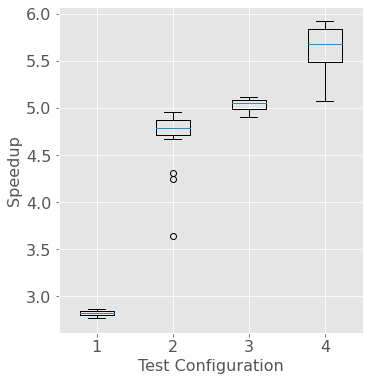

In [9]:
plt.figure(4, figsize=(12, 6))

plt.subplot(121)
_ = plt.boxplot(speedup_df.T)
plt.xlabel("Test Configuration", fontsize=FONTSIZE)
plt.ylabel("Speedup", fontsize=FONTSIZE)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)